In [106]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
plt.style.use('seaborn')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.width = 0

def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf.flatten(),index=eVal.flatten())
    return pdf

def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec

def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:
        obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:
        x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

"""
 FITTING
 THE
 MARCENKO–PASTUR PDF
"""
from scipy.optimize import minimize
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    return sse

def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    out=minimize(lambda *x: errPDFs(*x), .5 , args=(eVal,q,bWidth),
                    bounds=((1E-5,1-1E-5),)
                )
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax, var

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

### Import new CC data

In [107]:
result = pd.read_csv('~/Works/practicum_github_repo/Crypto-Data/ml_finance/daily_closing_300cc_yf.csv')

In [108]:
result

,Date,BTC-USD,ETH-USD,USDT-USD,BNB-USD,ADA-USD,XRP-USD,DOGE-USD,USDC-USD,DOT1-USD,HEX-USD,UNI3-USD,BCH-USD,LTC-USD,SOL1-USD,LINK-USD,MATIC-USD,THETA-USD,ETC-USD,XLM-USD,ICP1-USD,VET-USD,FIL-USD,TRX-USD,AAVE-USD,EOS-USD,XMR-USD,LUNA1-USD,CRO-USD,ATOM1-USD,SHIB-USD,ALGO-USD,MKR-USD,BSV-USD,XTZ-USD,NEO-USD,COMP-USD,MIOTA-USD,AMP1-USD,AVAX-USD,GRT2-USD,CCXX-USD,TFUEL-USD,KSM-USD,DCR-USD,EGLD-USD,BTT1-USD,STX1-USD,HBAR-USD,CHZ-USD,TUSD-USD,WAVES-USD,CEL-USD,RUNE-USD,SNX-USD,CTC1-USD,ZEC-USD,DASH-USD,YFI-USD,MANA-USD,HNT1-USD,ENJ-USD,XDC-USD,XEM-USD,SUSHI-USD,HOT1-USD,QNT-USD,ONE2-USD,ZIL-USD,BAT-USD,BTG-USD,CELO-USD,BNT-USD,ZEN-USD,XWC-USD,DFI-USD,CRV-USD,ZRX-USD,QTUM-USD,NANO-USD,SC-USD,ONT-USD,ICX-USD,DGB-USD,OMG-USD,UMA-USD,ANKR-USD,VGX-USD,RVN-USD,BCD-USD,AR-USD,ARRR-USD,IOST-USD,XVG-USD,SAND-USD,LSK-USD,GLM-USD,RSR-USD,KNC-USD,KAVA-USD,MAID-USD,CKB-USD,MIR1-USD,LRC-USD,BCN-USD,GNO-USD,STORJ-USD,DAG-USD,RLC-USD,SNT-USD,BAND-USD,HNC-USD,VTHO-USD,STRAX-USD,WAXP-USD,OXT-USD,FET-USD,TOMO-USD,ERG-USD,IOTX-USD,REP-USD,STEEM-USD,FUN-USD,EWT-USD,ARDR-USD,MCO-USD,MLN-USD,CVC-USD,SRM-USD,NU-USD,NKN-USD,BAL-USD,META-USD,ANT-USD,PHA-USD,ABBC-USD,MED-USD,SAPP-USD,HIVE-USD,ARK-USD,BTS-USD,WAN-USD,ETN-USD,MTL-USD,DIVI-USD,AVA-USD,PPT-USD,XNC-USD,PAC-USD,KMD-USD,VLX-USD,COTI-USD,BTM-USD,MONA-USD,NYE-USD,SYS-USD,HNS-USD,TWT-USD,WOZX-USD,KIN-USD,DERO-USD,IRIS-USD,NRG-USD,DNT-USD,RBTC-USD,REV-USD,DMCH-USD,XHV-USD,SERO-USD,AION-USD,GAS-USD,TT-USD,FIRO-USD,RDD-USD,FIO-USD,BURST-USD,ATRI-USD,SNM-USD,APL-USD,GRS-USD,SBD-USD,CRU-USD,AXEL-USD,ZNN-USD,MWC-USD,KDA-USD,BEAM-USD,VRA-USD,ELA-USD,LOKI-USD,VSYS-USD,WTC-USD,ADX-USD,NIM-USD,CET-USD,MASS-USD,NULS-USD,KRT-USD,PIVX-USD,WICC-USD,DGD-USD,VERI-USD,NXS-USD,GXC-USD,AE-USD,SRK-USD,PCX-USD,PLC-USD,VTC-USD,HC-USD,NAV-USD,FSN-USD,CTXC-USD,MHC-USD,QASH-USD,MARO-USD,PPC-USD,PAI-USD,PZM-USD,VITE-USD,BEPRO-USD,ZANO-USD,CUT-USD,GO-USD,GRIN-USD,ZEL-USD,SOLVE-USD,NAS-USD,NMC-USD,SKY-USD,XSN-USD,ADK-USD,GBYTE-USD,NEBL-USD,BIP-USD,GAME-USD,LBC-USD,SALT-USD,WABI-USD,QRL-USD,DNA1-USD,RSTR-USD,NLG-USD,PART-USD,NXT-USD,NVT-USD,FCT-USD,ETP-USD,VAL1-USD,BHP-USD,PAY-USD,DCN-USD,MRX-USD,TRUE-USD,POA-USD,VIA-USD,AEON-USD,BHD-USD,DYN-USD,GHOST1-USD,LCC-USD,ZYN-USD,BTC2-USD,UBQ-USD,CMT1-USD,ACT-USD,HPB-USD,TRTL-USD,BLOCK-USD,HTML-USD,DMD-USD,SMART-USD,SFT-USD,WGR-USD,OBSR-USD,SCC3-USD,VEX-USD,BTX-USD,XMC-USD,INSTAR-USD,DTEP-USD,PMEER-USD,HTDF-USD,FLO-USD,EMC2-USD,YOYOW-USD,AMB-USD,ACH-USD,PI-USD,RINGX-USD,MAN-USD,FTC-USD,SNGLS-USD,CHI-USD,XDN-USD,GLEEC-USD,XMY-USD,FO-USD,PHR-USD,VITAE-USD,INT-USD
0,2014-09-17,457.334015,NaN,NaN,NaN,NaN,0.005399,0.000268,NaN,NaN,NaN,NaN,NaN,5.058550,NaN,NaN,NaN,NaN,NaN,0.003072,NaN,NaN,NaN,NaN,NaN,NaN,1.768350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.753940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020250,NaN,NaN,NaN,0.000016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.110163,NaN,0.001280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000065,NaN,0.000895,NaN,NaN,NaN,0.001182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097816,NaN,0.001145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,424.440002,NaN,NaN,NaN,NaN,0.005135,0.000298,NaN,NaN,NaN,NaN,NaN,4.685230,NaN,NaN,NaN,NaN,NaN,0.003456,NaN,NaN,NaN,NaN,

In [109]:
result['Date'] = pd.to_datetime(result.Date)

In [110]:
result = result.set_index('Date').resample('D').asfreq().ffill()
# get data after Nov 2017
result = result.query('Date >= "2017-11-01"').dropna(axis=1)#.shape

In [11]:
# # result['date'] = pd.to_datetime(result['date'], format='%d/%m/%Y')
# # result = result.dropna()
# result.date.max() #.set_index('Date')
# result = result.set_index('date')
# # result = result[(result.index >= '2017-01-01') & ((result.index <= '2017-12-31'))]
# result = result.astype(float)

In [5]:
result

,BTC,ETH,XRP,USDT,BCH,BSV,LTC,EOS,BNB,XTZ,...,BNT,LOKI,PPT,IOTX,YOU,EDC,XMX,R,FTM,WINK
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,3843.52,140.82,0.364771,1.020000,164.85,92.14,31.98,2.66,6.08,0.474699,...,0.650842,0.211717,1.490000,0.007938,0.005066,0.009271,0.000220,0.256234,0.006609,0.000117
2019-01-02,3943.41,155.05,0.375243,1.020000,171.83,94.88,33.43,2.89,6.19,0.485319,...,0.701499,0.205480,1.560000,0.008092,0.005156,0.009184,0.000222,0.246156,0.006963,0.000117
2019-01-03,3836.74,149.14,0.360224,1.020000,162.05,88.64,32.03,2.68,5.90,0.482134,...,0.672790,0.207348,1.480000,0.008041,0.005036,0.008851,0.000215,0.268940,0.006447,0.000117
2019-01-04,3857.72,154.58,0.356747,1.020000,161.40,87.65,32.40,2.72,6.07,0.483029,...,0.689961,0.202332,1.480000,0.007932,0.005029,0.008823,0.000209,0.248345,0.006387,0.000117
2019-01-05,3845.19,155.64,0.355275,1.020000,160.40,88.52,34.94,2.70,6.07,0.483224,...,0.698831,0.209437,1.500000,0.007905,0.004909,0.008697,0.000218,0.257743,0.006037,0.000117
2019-01-06,4076.63,157.75,0.368395,1.020000,166.84,90.38,39.30,2.88,6.40,0.484338,...,0.702547,0.224148,1.570000,0.008349,0.005138,0.008668,0.000227,0.275129,0.005731,0.000117
2019-01-07,4025.25,151.70,0.364347,1.010000,161.24,88.78,37.81,2.77,6.29,0.481431,...,0.684739,0.219533,1.550000,0.008232,0.004975,0.008535,0.000216,0.259324,0.005957,0.000117
2019-01-08,4030.85,150.36,0.365315,1.020000,161.91,87.58,39.48,2.80,6.64,0.484993,...,0.674858,0.218394,1.520000,0.007977,0.004917,0.008689,0.000226,0.258775,0.005847,0.000117
2019-01-09,4035.30,150.80,0.370890,1.020000,160.08,87.04,38.99,2.91,6.64,0.495942,...,0.678107,0.218522,1.530000,0.008140,0.004980,0.008594,0.000219,0.237447,0.005857,0.000161


In [111]:
# remove any stable/fiat coins
result = result.loc[:, ~result.columns.isin(['USDT-USD', 'PAX-USD', 'TUSD-USD', 'USDC-USD', 'EURS-USD', 'SAI-USD'])]

In [112]:
returns = result.pct_change().iloc[1:, :].copy()
# returns.dropna(axis = 1, thresh=len(returns.index)/2, inplace=True) # Drop stocks with over half the data missing
# returns.dropna(axis = 0, thresh=len(returns.columns), inplace=True) # Drop days without data for all stocks

In [113]:
returns

,BTC-USD,ETH-USD,BNB-USD,ADA-USD,XRP-USD,DOGE-USD,BCH-USD,LTC-USD,LINK-USD,ETC-USD,XLM-USD,TRX-USD,EOS-USD,XMR-USD,MKR-USD,XTZ-USD,NEO-USD,MIOTA-USD,DCR-USD,WAVES-USD,ZEC-USD,DASH-USD,MANA-USD,ENJ-USD,XEM-USD,BAT-USD,BTG-USD,BNT-USD,ZEN-USD,XWC-USD,ZRX-USD,QTUM-USD,NANO-USD,SC-USD,ICX-USD,DGB-USD,OMG-USD,XVG-USD,SAND-USD,LSK-USD,KNC-USD,MAID-USD,LRC-USD,BCN-USD,GNO-USD,STORJ-USD,RLC-USD,SNT-USD,HNC-USD,REP-USD,STEEM-USD,FUN-USD,ARDR-USD,MCO-USD,MLN-USD,CVC-USD,ANT-USD,ARK-USD,BTS-USD,MTL-USD,PPT-USD,PAC-USD,KMD-USD,BTM-USD,MONA-USD,SYS-USD,KIN-USD,DNT-USD,REV-USD,AION-USD,GAS-USD,RDD-USD,BURST-USD,SNM-USD,GRS-USD,SBD-USD,WTC-USD,ADX-USD,NULS-USD,PIVX-USD,DGD-USD,VERI-USD,NXS-USD,AE-USD,VTC-USD,HC-USD,NAV-USD,NMC-USD,GBYTE-USD,NEBL-USD,GAME-USD,SALT-USD,QRL-USD,PART-USD,NXT-USD,FCT-USD,ETP-USD,PAY-USD,DCN-USD,VIA-USD,UBQ-USD,BLOCK-USD,SMART-USD,YOYOW-USD,SNGLS-USD,XDN-USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-02,0.045984,-0.014622,0.030193,-0.073088,0.060461,0.011424,0.104158,0.029268,0.062280,-0.002377,0.009286,-0.078885,0.067280,-0.022789,0.000000,-0.062446,-0.087858,0.005869,-0.077299,0.101123,-0.019113,-0.023037,-0.034405,-0.132881,0.001452,0.205338,-0.119920,-0.074347,-0.001500,0.044321,-0.002569,-0.012846,-0.145427,0.004948,0.085379,-0.047937,0.029254,-0.055129,0.000000,-0.040715,-0.014686,-0.112180,-0.120495,-0.131821,-0.122999,0.250299,0.119080,-0.228558,-0.158353,-0.045585,-0.002853,0.000373,0.199590,-0.033419,-0.072694,-0.080258,-0.111073,0.004585,-0.103902,-0.076223,-0.107288,0.000000,0.142898,0.034170,0.012991,0.237588,-0.166667,-0.001832,0.00000,0.126822,-0.034494,-0.136722,-0.104444,0.075342,-0.333623,-0.002809,-0.093253,-0.045103,0.147825,0.006421,0.052443,0.060557,-0.131003,-0.010522,-0.176267,-0.044222,-0.104112,0.000000,-0.030645,-0.036174,-0.038489,0.020196,0.004980,-0.002466,0.095469,-0.074775,-0.082789,0.014084,-0.021686,0.000000,-0.018907,0.001575,-0.160179,0.000000,-0.140556,0.000000
2017-11-03,0.018261,0.063605,0.122796,0.062048,0.011037,-0.026064,0.064885,0.026382,0.026107,0.236740,0.006230,-0.036765,0.085611,0.050420,0.000000,0.080969,0.094590,0.073950,0.112834,0.155739,0.066327,0.050071,0.068327,0.177422,0.029008,-0.120452,0.033402,0.085440,0.396156,0.092633,0.050156,0.059887,0.030092,-0.025438,0.153320,0.121606,0.079902,0.203281,0.000000,0.048973,0.041463,-0.024996,0.031064,0.000000,0.023866,-0.060580,-0.122001,-0.069959,0.058574,0.101847,0.067644,0.025461,-0.130459,0.094198,0.113742,0.038017,0.060960,0.180547,-0.008323,0.161896,0.126643,0.000000,0.008809,0.293623,-0.030778,-0.140430,0.225000,0.054184,0.00000,0.060085,0.142636,0.166497,0.044474,0.038546,-0.126388,-0.012098,0.088296,0.087121,0.060891,0.047468,0.130465,0.066239,0.005499,0.245142,0.100516,-0.029919,0.058196,0.000000,0.042815,-0.001875,0.022619,0.123563,-0.081559,-0.009141,-0.067659,0.249280,0.079809,0.118928,0.036035,0.000000,-0.023260,0.013224,-0.041104,0.000000,0.133206,0.000000
2017-11-04,0.023890,-0.017147,0.121969,-0.026781,-0.021059,0.060660,-0.007802,-0.020366,0.033790,-0.060931,-0.017459,-0.044454,-0.075120,-0.007777,0.000000,0.012892,-0.012401,-0.062278,0.047857,-0.016271,-0.009629,-0.014035,0.090582,-0.088691,-0.005142,-0.034908,0.078974,-0.003204,-0.135917,0.258375,0.020148,-0.032645,0.012663,-0.004210,0.038962,-0.037845,-0.041340,0.084469,0.000000,0.011656,0.052926,0.025924,-0.027939,0.023673,0.025223,-0.061816,-0.024051,0.023875,-0.105295,-0.023025,-0.032679,-0.006601,-0.060440,-0.048542,-0.005566,0.012418,0.074284,-0.068236,0.044470,-0.116782,0.030505,0.000000,-0.029285,0.031573,-0.011291,-0.091063,-0.061224,-0.006730,0.00000,-0.032270,-0.017337,-0.035683,0.017544,-0.022970,0.561064,0.006802,0.042279,-0.020187,-0.124059,-0.031571,-0.002959,0.000246,0.099436,0.190611,0.089796,0.034736,0.016860,0.000000,-0.165285,-0.084207,-0.013723,-0.090987,0.045793,0.096549,-0.013071,-0.026528,-0.073205,-0.047917,-0.318569,0.000000,0.004798,0.039190,-0.066803

In [114]:
# n = 120  #chunk row size
# list_df = [returns[i:i+n] for i in range(0,returns.shape[0],n)]

# [i.shape for i in list_df]


size = 120      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-90) if i < len(returns)-90]

[l_d.shape for l_d in list_of_dfs]

[(120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (120, 106),
 (119, 106)]

In [115]:
training_period = 30
in_sample = returns.iloc[:(returns.shape[0]-training_period), :].copy()

In [116]:
tickers = returns.columns

In [117]:
pd.set_option('use_inf_as_na', True)
in_sample_log_returns = np.log(1+in_sample)
# log_returns.dropna(0, inplace= True)
# log_returns.dropna(1, inplace= True)

In [118]:
# Shapiro-Wilk Test For Gausiannity 
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
# data = 5 * randn(100) + 50
# normality test
for i in range(len(in_sample_log_returns.columns)):
    stat, p = shapiro(in_sample_log_returns.iloc[:, i].values)
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print(i)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        pass
#         print('Sample does not look Gaussian (reject H0)')

In [119]:
# Shapiro-Wilk Test For Gausiannity 
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
# seed the random number generator
seed(1)
# generate univariate observations
# data = 5 * randn(100) + 50
# normality test
for i in range(len(in_sample_log_returns.columns)):
    stat, p = normaltest(in_sample_log_returns.iloc[:, i].values)
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print(i)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        pass
#         print('Sample does not look Gaussian (reject H0)')

In [120]:
# We will need the standard deviations later:
variances = np.diag(in_sample_log_returns.cov().values)
standard_deviations = np.sqrt(variances) 

In [121]:
corr_mat = in_sample_log_returns.interpolate().corr('spearman')

In [122]:
"""
Start with CCs correlation matrix 
"""
eVal0,eVec0=getPCA(corr_mat)

In [123]:
q = returns.shape[0]/corr_mat.shape[0]

In [124]:
# get bulk of Evalue and Variance
eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
# get nFacts
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

In [125]:
nFacts0

3

In [126]:
var0

0.99999

In [127]:
eMax0

1.6391911315011654

In [128]:
D, S = np.linalg.eigh(corr_mat)

print(D[D > eMax0])

[ 1.88147889  2.20149482 48.39295858]


In [129]:
len(D)

106

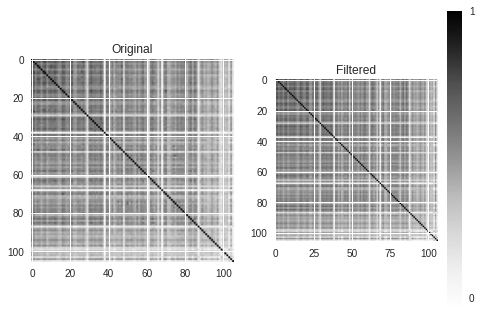

In [130]:
# Filter the eigenvalues out
D[D <= eMax0] = 0

# Reconstruct the matrix
temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))

# Set the diagonal entries to 0
np.fill_diagonal(temp, 1)
filtered_matrix = temp

f = plt.figure()
ax = plt.subplot(121)
ax.imshow(corr_mat)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(filtered_matrix)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

In [131]:
nFacts0

3

In [132]:
"""
 SNIPPET 2.5 DENOISING
 BY
 CONSTANT RESIDUAL EIGENVALUE
"""
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

# get denoised correlation matrix
corr1=denoisedCorr(eVal0,eVec0,nFacts0)
eVal1,eVec1=getPCA(corr1)

In [133]:
eVal2,eVec2=getPCA(filtered_matrix)

In [134]:
findMaxEval(np.diag(eVec1), q, bWidth=.01)

(1.6391911315011654, 0.99999)

In [135]:
findMaxEval(np.diag(eVec2), q, bWidth=.01)

(1.6391911315011654, 0.99999)

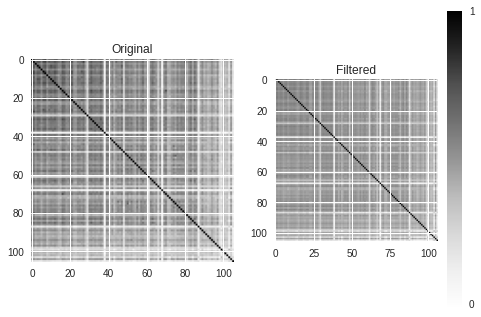

In [136]:
f = plt.figure()
ax = plt.subplot(121)
ax.imshow(corr_mat)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(corr1)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

In [32]:
in_sample

,BTC,ETH,XRP,BCH,BSV,LTC,EOS,BNB,XTZ,LINK,...,BNT,LOKI,PPT,IOTX,YOU,EDC,XMX,R,FTM,WINK
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.025989,0.101051,0.028708,0.042342,0.029737,0.045341,0.086466,0.018092,0.022372,0.057180,...,0.077833,-0.029459,0.046980,0.019400,0.017765,-0.009384,0.009091,-0.039331,0.053563,0.000000
2019-01-03,-0.027050,-0.038117,-0.040025,-0.056917,-0.065767,-0.041879,-0.072664,-0.046850,-0.006563,0.156356,...,-0.040925,0.009091,-0.051282,-0.006303,-0.023274,-0.036259,-0.031532,0.092559,-0.074106,0.000000
2019-01-04,0.005468,0.036476,-0.009652,-0.004011,-0.011169,0.011552,0.014925,0.028814,0.001856,0.194552,...,0.025522,-0.024191,0.000000,-0.013556,-0.001390,-0.003163,-0.027907,-0.076578,-0.009307,0.000000
2019-01-05,-0.003248,0.006857,-0.004126,-0.006196,0.009926,0.078395,-0.007353,0.000000,0.000404,-0.094303,...,0.012856,0.035116,0.013514,-0.003404,-0.023862,-0.014281,0.043062,0.037843,-0.054799,0.000000
2019-01-06,0.060189,0.013557,0.036929,0.040150,0.021012,0.124785,0.066667,0.054366,0.002305,0.002682,...,0.005317,0.070241,0.046667,0.056167,0.046649,-0.003334,0.041284,0.067455,-0.050687,0.000000
2019-01-07,-0.012604,-0.038352,-0.010988,-0.033565,-0.017703,-0.037913,-0.038194,-0.017188,-0.006002,-0.051727,...,-0.025348,-0.020589,-0.012739,-0.014014,-0.031724,-0.015344,-0.048458,-0.057446,0.039435,0.000000
2019-01-08,0.001391,-0.008833,0.002657,0.004155,-0.013517,0.044168,0.010830,0.055644,0.007399,0.126766,...,-0.014430,-0.005188,-0.019355,-0.030977,-0.011658,0.018043,0.046296,-0.002117,-0.018466,0.000000
2019-01-09,0.001104,0.002926,0.015261,-0.011303,-0.006166,-0.012411,0.039286,0.000000,0.022576,-0.052789,...,0.004814,0.000586,0.006579,0.020434,0.012813,-0.010933,-0.030973,-0.082419,0.001710,0.376068
2019-01-10,-0.088316,-0.147016,-0.103098,-0.156859,-0.127757,-0.131316,-0.161512,-0.108434,-0.086923,-0.117472,...,-0.138755,-0.077448,-0.156863,-0.148526,-0.032129,-0.090761,0.050228,-0.184706,-0.104490,-0.093168


## After taking out tether portfolio much more reasonable here

/home/harshal/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


           Investment Weight
BTC-USD             0.405368
NMC-USD             0.163748
REV-USD             0.150346
YOYOW-USD           0.131486
ETH-USD             0.077909


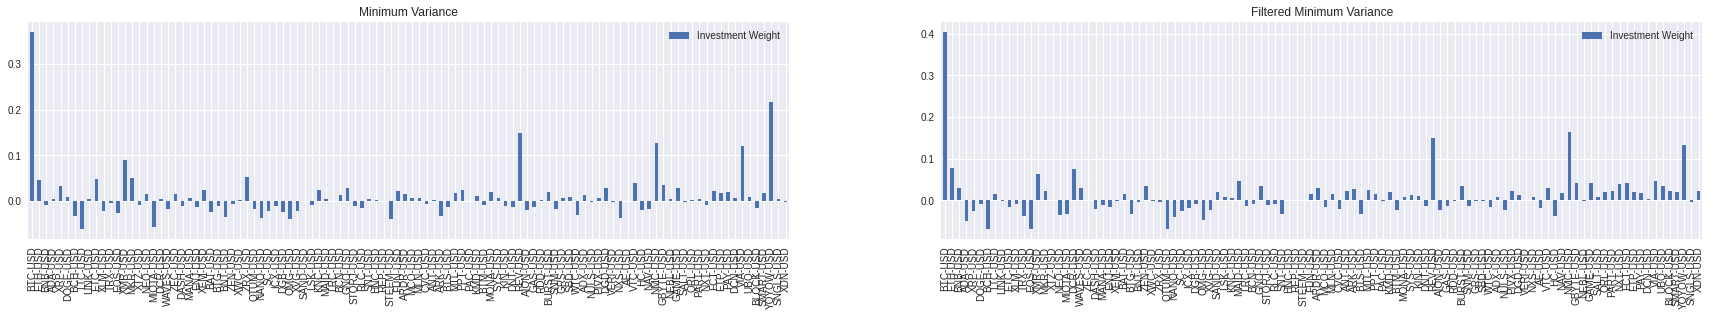

In [39]:
# Reconstruct the filtered covariance matrix
covariance_matrix = in_sample.cov()
inv_cov_mat = np.linalg.pinv(covariance_matrix)

# Construct minimum variance weights
ones = np.ones(len(inv_cov_mat))
inv_dot_ones = np.dot(inv_cov_mat, ones)
min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

plt.figure(figsize=(30,4))

ax = plt.subplot(121)
min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Minimum Variance')

# Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
filtered_cov = np.dot(np.diag(standard_deviations), 
                           np.dot(filtered_matrix,np.diag(standard_deviations)))

filt_inv_cov = np.linalg.pinv(filtered_cov)

# Construct minimum variance weights
ones = np.ones(len(filt_inv_cov))
inv_dot_ones = np.dot(filt_inv_cov, ones)
filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
ax = plt.subplot(122)
filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
filt_min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Filtered Minimum Variance')

print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

## Interesting as the MVR portfolio doesn't offer much better returns here, possibly because of 2017 inflation?

Text(0.5, 1.0, 'Filtered (Red) vs. Normal (Black)')

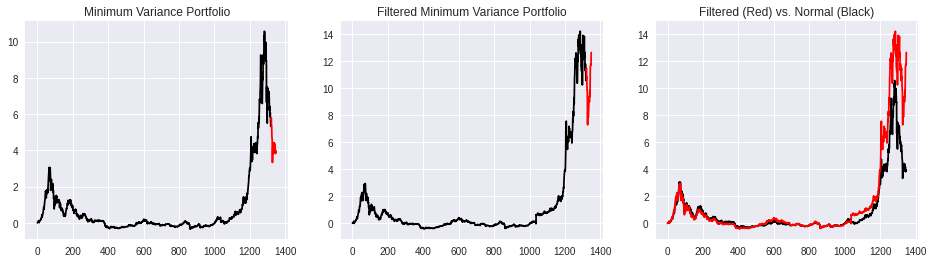

In [40]:
def get_cumulative_returns_over_time(sample, weights):
    # Ignoring short sales
    weights[weights <= 0 ] = 0 
    weights = weights / weights.sum()
    return (((1+sample).cumprod(axis=0))-1).dot(weights)

in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period), returns.shape[0])

cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
cumulative_returns_filt = get_cumulative_returns_over_time(returns, filt_min_var_portfolio).values

f = plt.figure(figsize=(16,4))

ax = plt.subplot(131)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Minimum Variance Portfolio")

ax = plt.subplot(132)
ax.plot(cumulative_returns_filt[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns_filt[out_sample_ind], 'r')
plt.title("Filtered Minimum Variance Portfolio")

ax = plt.subplot(133)
ax.plot(cumulative_returns, 'black')
ax.plot(cumulative_returns_filt, 'r')
plt.title("Filtered (Red) vs. Normal (Black)")

In [41]:
print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

           Investment Weight
BTC-USD             0.405368
NMC-USD             0.163748
REV-USD             0.150346
YOYOW-USD           0.131486
ETH-USD             0.077909


### Sliding window Min Var Portfolios

In [42]:
def create_filtered_portfolios(returns, test_period):

    # test_period = 30
    in_sample = returns.iloc[:(returns.shape[0]-test_period), :].copy()
    in_sample_log_returns = np.log(1+in_sample)

    # We will need the standard deviations later:
    variances = np.diag(in_sample_log_returns.cov().values)
    standard_deviations = np.sqrt(variances) 
    corr_mat = in_sample_log_returns.interpolate().corr('spearman')

    eVal0,eVec0=getPCA(corr_mat)
    q = returns.shape[0]/corr_mat.shape[0]

    # get bulk of Evalue and Variance
    eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
    # get nFacts
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)


    D, S = np.linalg.eigh(corr_mat)
    print(D[D > eMax0])
    # Filter the eigenvalues out
    D[D <= eMax0] = 0
    # Reconstruct the matrix
    temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))
    # Set the diagonal entries to 0
    np.fill_diagonal(temp, 1)
    filtered_matrix = temp



    # Reconstruct the filtered covariance matrix
    covariance_matrix = in_sample.cov()
    inv_cov_mat = np.linalg.pinv(covariance_matrix)

    # Construct minimum variance weights
    ones = np.ones(len(inv_cov_mat))
    inv_dot_ones = np.dot(inv_cov_mat, ones)
    min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

    min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                    columns = ['Investment Weight'],
                                    index = tickers)
    # Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
    filtered_cov = np.dot(np.diag(standard_deviations), 
                            np.dot(filtered_matrix,np.diag(standard_deviations)))
    filt_inv_cov = np.linalg.pinv(filtered_cov)

    # Construct minimum variance weights
    ones = np.ones(len(filt_inv_cov))
    inv_dot_ones = np.dot(filt_inv_cov, ones)
    filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
    filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                    columns = ['Investment Weight'],
                                    index = tickers)

    def get_cumulative_returns_over_time(sample, weights):
        # Ignoring short sales
        weights[weights <= 0 ] = 0 
        weights = weights / weights.sum()
        return (((1+sample).cumprod(axis=0))-1).dot(weights)

    in_sample_ind = np.arange(0, (returns.shape[0]-test_period+1))
    out_sample_ind = np.arange((returns.shape[0]-test_period), returns.shape[0])

    cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
    cumulative_returns_filt = get_cumulative_returns_over_time(returns, filt_min_var_portfolio).values
    
    f = plt.figure(figsize=(16,4))

    ax = plt.subplot(131)
    ax.plot(cumulative_returns[in_sample_ind], 'black')
    ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
    plt.title("Minimum Variance Portfolio")

    ax = plt.subplot(132)
    ax.plot(cumulative_returns_filt[in_sample_ind], 'black')
    ax.plot(out_sample_ind,cumulative_returns_filt[out_sample_ind], 'r')
    plt.title("Filtered Minimum Variance Portfolio")

    ax = plt.subplot(133)
    ax.plot(cumulative_returns, 'black')
    ax.plot(cumulative_returns_filt, 'r')
    plt.title("Filtered (Red) vs. Normal (Black)")

    return None

In [43]:
size = 180      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-90) if i < len(returns)-90]

[l_d.shape for l_d in list_of_dfs]
[create_filtered_portfolios(l_d, 30) for l_d in list_of_dfs]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [44]:
size = 120      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-30) if i < len(returns)-30]

[l_d.shape for l_d in list_of_dfs]
[create_filtered_portfolios(l_d, 30) for l_d in list_of_dfs]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Ward Method

In [137]:
## First step is to calculate the distance matrix from the filtered matrix 
## next get condensed matrix from distance matrix (i.e the upper traingular of distance matrix)
def compute_distance_matrix(corr_mat, tickers):
    """
    Computes Correlation Matrix from the CC matrix, 
    and computes distance matrix from correlation matrix
    
    returns:
        - Distance matrix dataframe
    """
    
    ## Distance formula d(i,j) = 1-p(i,j)^2
    dist_mat = corr_mat
    for i in range(len(corr_mat)):
        for j in range(len(corr_mat)):
            dist_mat[i][j] = 1 - (corr_mat[i][j]**2)
    

    # add CC names
    df_dist_mat = pd.DataFrame(dist_mat, columns=tickers, index=tickers)
    
    return df_dist_mat

dist_mat_df = compute_distance_matrix(filtered_matrix.copy(), tickers)
# np.fill_diagonal(dist_mat_df.values, 0)
# import scipy.spatial.distance as ssd
# aa = ssd.squareform(dist_mat_df.values)

In [138]:
aa = dist_mat_df.copy()

In [139]:
aa = np.nan_to_num(aa.values)

In [140]:
aa

array([[0.        , 0.42072225, 0.63241097, ..., 0.97439619, 0.78741697,
        0.98329282],
       [0.42072225, 0.        , 0.57126259, ..., 0.9295044 , 0.71834488,
        0.96243623],
       [0.63241097, 0.57126259, 0.        , ..., 0.95564071, 0.78592301,
        0.97910208],
       ...,
       [0.97439619, 0.9295044 , 0.95564071, ..., 0.        , 0.94214192,
        0.9193215 ],
       [0.78741697, 0.71834488, 0.78592301, ..., 0.94214192, 0.        ,
        0.98209497],
       [0.98329282, 0.96243623, 0.97910208, ..., 0.9193215 , 0.98209497,
        0.        ]])

In [141]:
import scipy.spatial.distance as ssd
cond = ssd.squareform(aa, checks=False)

In [142]:
cond.shape

(5565,)

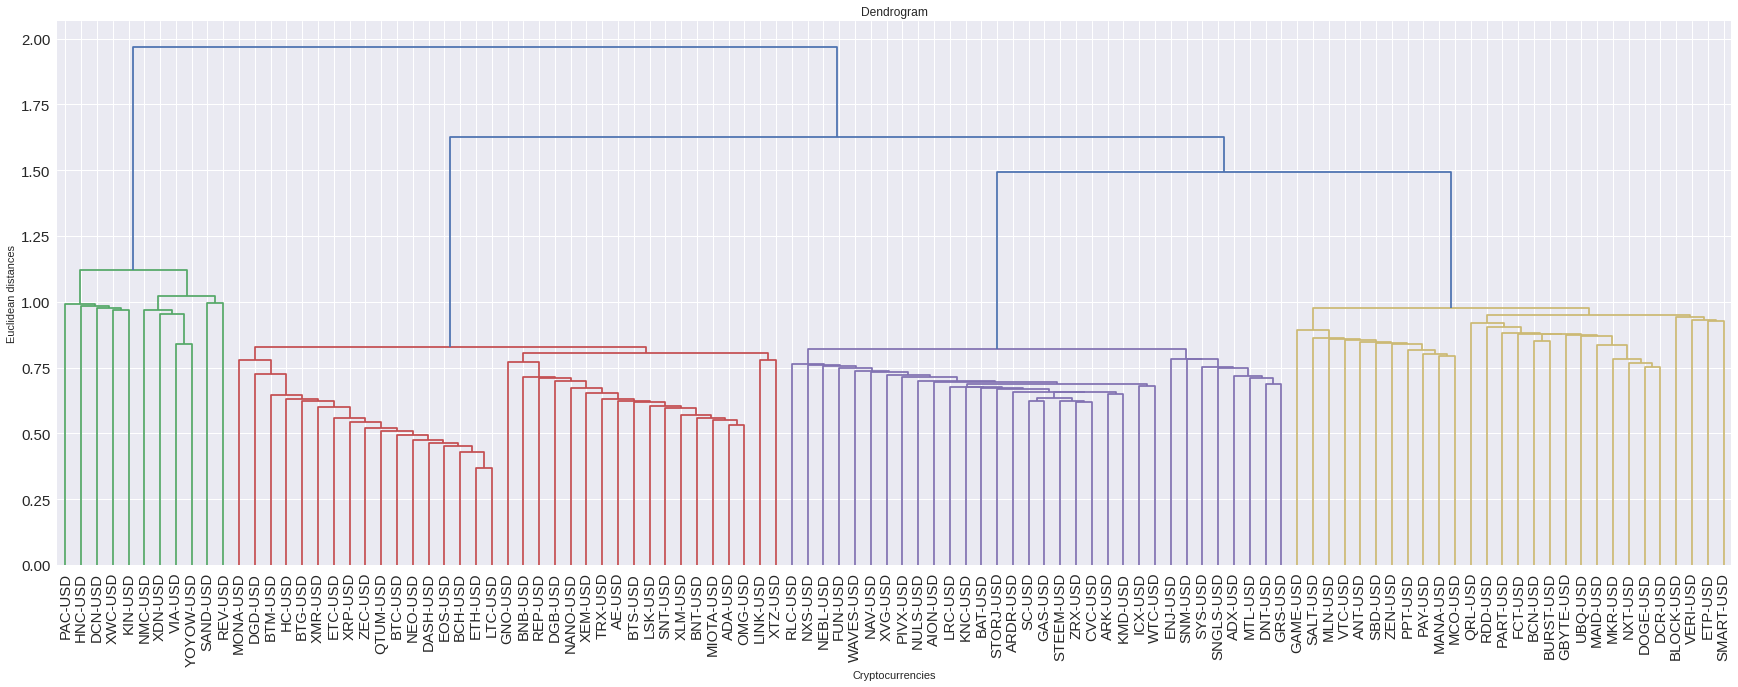

In [143]:
# Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and
# then in linkage we have to #specify on which data we apply and engage. 
# This is X dataset
import scipy.cluster.hierarchy as sch 
plt.figure(figsize=(30,10))

dendrogram = sch.dendrogram(sch.linkage(cond, method  = "ward"), labels = tickers)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Dendrogram')
plt.xlabel('Cryptocurrencies')
plt.ylabel('Euclidean distances')
plt.savefig('dendrogram.jpg')
plt.show()

In [144]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 8, affinity = 'euclidean', linkage ='ward')

In [145]:
np.reshape(cond, (-1, 1))

array([[0.42072225],
       [0.63241097],
       [0.53432496],
       ...,
       [0.94214192],
       [0.9193215 ],
       [0.98209497]])

In [146]:
y_hc=hc.fit_predict(np.reshape(cond, (-1, 1)))

In [147]:
class_labels = ssd.squareform(y_hc, checks=False)[[0]]

In [148]:
some_list = list(zip(list(class_labels)[0], list(tickers)))

In [149]:
clusters_ward = pd.DataFrame(some_list, columns=['class_number', 'tickers'])


In [150]:
unstacked = clusters_ward.groupby(['class_number', 'tickers'])['tickers'].sum().unstack()

In [151]:
unstacked_2 = pd.concat([s.dropna().reset_index(drop=True) for i,s in unstacked.iterrows()], 1).T


In [152]:
unstacked_2.replace(np.nan, '', regex=True, inplace=True)

In [153]:
# unstacked_2.to_latex()

In [154]:
hd = dict()
for k in range(len(unstacked)):
    print(f'{k}: {unstacked.iloc[k].dropna().values}\n')


0: ['BTC-USD' 'DCN-USD' 'HNC-USD' 'KIN-USD' 'PAC-USD' 'XWC-USD']

1: ['ADA-USD' 'BCH-USD' 'BNT-USD' 'BTG-USD' 'DASH-USD' 'EOS-USD' 'ETC-USD'
 'ETH-USD' 'HC-USD' 'LTC-USD' 'MIOTA-USD' 'NEO-USD' 'OMG-USD' 'QTUM-USD'
 'TRX-USD' 'XLM-USD' 'XMR-USD' 'XRP-USD' 'ZEC-USD']

2: ['AE-USD' 'BNB-USD' 'BTM-USD' 'BTS-USD' 'DCR-USD' 'DGB-USD' 'DGD-USD'
 'DOGE-USD' 'GAS-USD' 'LSK-USD' 'MONA-USD' 'NANO-USD' 'SC-USD' 'SNT-USD'
 'XEM-USD' 'ZRX-USD']

3: ['BLOCK-USD' 'ETP-USD' 'GAME-USD' 'MTL-USD' 'RDD-USD' 'SMART-USD'
 'VERI-USD']

4: ['AION-USD' 'ARDR-USD' 'ARK-USD' 'BCN-USD' 'CVC-USD' 'FUN-USD' 'GBYTE-USD'
 'KMD-USD' 'LINK-USD' 'MAID-USD' 'MCO-USD' 'MLN-USD' 'NAV-USD' 'NEBL-USD'
 'NULS-USD' 'NXS-USD' 'PAY-USD' 'PIVX-USD' 'RLC-USD' 'STORJ-USD'
 'WAVES-USD' 'WTC-USD' 'ZEN-USD']

5: ['NMC-USD' 'REV-USD' 'SAND-USD' 'VIA-USD' 'XDN-USD' 'YOYOW-USD']

6: ['ADX-USD' 'ANT-USD' 'BURST-USD' 'DNT-USD' 'ENJ-USD' 'FCT-USD' 'GRS-USD'
 'MANA-USD' 'PART-USD' 'PPT-USD' 'QRL-USD' 'SALT-USD' 'SBD-USD'
 'SNGLS-USD' 'SNM-US

In [155]:
filt_min_var_portfolio[filt_min_var_portfolio>0].dropna()

,Investment Weight
BTC-USD,0.405368
ETH-USD,0.077909
BNB-USD,0.030003
LTC-USD,0.014120
XMR-USD,0.062904
MKR-USD,0.021444
XTZ-USD,0.000106
DCR-USD,0.075842
WAVES-USD,0.029764
ZEC-USD,0.001494


In [162]:
def ward_clustering(returns, test_period, tickers, **kwargs):
    
    print(f"Start period of window: {returns.index.min()}")
    # test_period = 30
    in_sample = returns.iloc[:(returns.shape[0]-test_period), :].copy()
    in_sample_log_returns = np.log(1+in_sample)

    # We will need the standard deviations later:
    variances = np.diag(in_sample_log_returns.cov().values)
    standard_deviations = np.sqrt(variances) 
    corr_mat = in_sample_log_returns.interpolate().corr('spearman')

    eVal0,eVec0=getPCA(corr_mat)
    q = returns.shape[0]/corr_mat.shape[0]

    # get bulk of Evalue and Variance
    eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
    # get nFacts
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)


    D, S = np.linalg.eigh(corr_mat)
    print(D[D > eMax0])
    # Filter the eigenvalues out
    D[D <= eMax0] = 0
    # Reconstruct the matrix
    temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))
    # Set the diagonal entries to 0
    np.fill_diagonal(temp, 1)
    filtered_matrix = temp


    # compute distance matrix
    dist_mat_df = compute_distance_matrix(filtered_matrix.copy(), tickers)

    aa = dist_mat_df.copy()
    # fill nan with 0s
    aa = np.nan_to_num(aa.values)

    import scipy.spatial.distance as ssd
    # convert to condensed matrix
    cond = ssd.squareform(aa, checks=False)

    # Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and
    # then in linkage we have to #specify on which data we apply and engage. 
    import scipy.cluster.hierarchy as sch 
    plt.figure(figsize=(30,10))

    # Create dendrogram
    dendrogram = sch.dendrogram(sch.linkage(cond, method  = "ward"), labels = tickers)

    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title('Dendrogram')
    plt.xlabel('Cryptocurrencies')
    plt.ylabel('Euclidean distances')
    plt.savefig(f'dendrogram_{dendo}.jpg')


    from sklearn.cluster import AgglomerativeClustering 
    # apply fixed number of clusters and fit cluster
    hc = AgglomerativeClustering(n_clusters = 8, affinity = 'euclidean', linkage ='ward')
    y_hc=hc.fit_predict(np.reshape(cond, (-1, 1)))

    class_labels = ssd.squareform(y_hc, checks=False)[[0]]
    some_list = list(zip(list(class_labels)[0], list(tickers)))
    clusters_ward = pd.DataFrame(some_list, columns=['class_number', 'tickers'])
    unstacked = clusters_ward.groupby(['class_number', 'tickers'])['tickers'].sum().unstack()
    unstacked_2 = pd.concat([s.dropna().reset_index(drop=True) for i,s in unstacked.iterrows()], 1).T
    unstacked_2.replace(np.nan, '', regex=True, inplace=True)
    display(unstacked_2)


In [64]:
result[['BTC', 'ETH', 'XRP', 'XMR']].log.plot()

KeyError: "None of [Index(['BTC', 'ETH', 'XRP', 'XMR'], dtype='object')] are in the [columns]"

In [73]:
pd.isna(result.iloc[1,0])

False

In [161]:
l_d.index.min()

Timestamp('2020-01-21 00:00:00', freq='D')

Start period of window: 2017-11-02 00:00:00
[40.91840492]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,ARK-USD,BTC-USD,CVC-USD,OMG-USD,XEM-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,AE-USD,ANT-USD,ARDR-USD,BCN-USD,BLOCK-USD,BNB-USD,BTM-USD,BTS-USD,DASH-USD,DGB-USD,DGD-USD,ENJ-USD,EOS-USD,ETC-USD,FUN-USD,GAS-USD,GBYTE-USD,GNO-USD,HC-USD,KMD-USD,KNC-USD,LRC-USD,LTC-USD,MAID-USD,MCO-USD,MIOTA-USD,MKR-USD,MLN-USD,NAV-USD,NEO-USD,NXS-USD,PIVX-USD,PPT-USD,QRL-USD,QTUM-USD,RDD-USD,REP-USD,SALT-USD,SC-USD,SNM-USD,STORJ-USD,WAVES-USD,WTC-USD,XLM-USD,XMR-USD,XRP-USD,ZEC-USD,ZEN-USD,ZRX-USD
3,AION-USD,BCH-USD,BTG-USD,BURST-USD,DCN-USD,ICX-USD,KIN-USD,LINK-USD,MANA-USD,MONA-USD,NANO-USD,NEBL-USD,NULS-USD,NXT-USD,PART-USD,SBD-USD,SNGLS-USD,TRX-USD,VERI-USD,XVG-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,ADA-USD,ADX-USD,BAT-USD,BNT-USD,DCR-USD,DNT-USD,DOGE-USD,ETH-USD,ETP-USD,FCT-USD,GAME-USD,GRS-USD,LSK-USD,MTL-USD,PAY-USD,RLC-USD,SNT-USD,STEEM-USD,SYS-USD,UBQ-USD,VTC-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,HNC-USD,PAC-USD,SMART-USD,XTZ-USD,XWC-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Start period of window: 2018-01-31 00:00:00
[ 1.23825194  1.37785021  1.43170676  1.64291129  1.92386059 67.82520255]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,BTC-USD,DCN-USD,HNC-USD,KIN-USD,NXS-USD,PAC-USD,SMART-USD,XTZ-USD,XVG-USD,XWC-USD,,,,,,,,,,,,,,,,
1,ADX-USD,AION-USD,ARDR-USD,BLOCK-USD,BNB-USD,DNT-USD,ETC-USD,FCT-USD,GAME-USD,GBYTE-USD,LRC-USD,MANA-USD,MONA-USD,MTL-USD,NANO-USD,NULS-USD,QRL-USD,SBD-USD,SNT-USD,STEEM-USD,TRX-USD,XEM-USD,,,,
2,DGD-USD,,,,,,,,,,,,,,,,,,,,,,,,,
3,AE-USD,ENJ-USD,EOS-USD,ETP-USD,NAV-USD,PART-USD,RDD-USD,SNM-USD,WTC-USD,ZEN-USD,,,,,,,,,,,,,,,,
5,ARK-USD,BCH-USD,BCN-USD,BNT-USD,BURST-USD,DASH-USD,DCR-USD,DGB-USD,ETH-USD,FUN-USD,GAS-USD,ICX-USD,KMD-USD,LSK-USD,LTC-USD,MIOTA-USD,MKR-USD,NEO-USD,NXT-USD,QTUM-USD,REP-USD,UBQ-USD,WAVES-USD,XMR-USD,XRP-USD,ZEC-USD
6,BTM-USD,GRS-USD,LINK-USD,PPT-USD,RLC-USD,SNGLS-USD,VERI-USD,,,,,,,,,,,,,,,,,,,
7,ADA-USD,ANT-USD,BAT-USD,BTG-USD,BTS-USD,CVC-USD,DOGE-USD,GNO-USD,HC-USD,KNC-USD,MAID-USD,MCO-USD,MLN-USD,NEBL-USD,OMG-USD,PAY-USD,PIVX-USD,SALT-USD,SC-USD,STORJ-USD,SYS-USD,VTC-USD,XLM-USD,ZRX-USD,,


Start period of window: 2018-05-01 00:00:00
[ 1.83320099  1.86112977  2.10499572 59.56490592]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,ANT-USD,BTC-USD,BTM-USD,BURST-USD,DCN-USD,DGD-USD,FCT-USD,KIN-USD,NULS-USD,PAC-USD,PAY-USD,PPT-USD,RLC-USD,SMART-USD,SNM-USD,ZRX-USD,,,,,,,,,,,,,,
1,ADA-USD,ADX-USD,BCH-USD,BNT-USD,BTS-USD,DASH-USD,ETH-USD,HC-USD,LSK-USD,LTC-USD,MTL-USD,NANO-USD,NEO-USD,NXT-USD,OMG-USD,QTUM-USD,SALT-USD,SC-USD,STORJ-USD,TRX-USD,WAVES-USD,XEM-USD,XLM-USD,XMR-USD,XRP-USD,XVG-USD,,,,
2,ARK-USD,BAT-USD,DOGE-USD,FUN-USD,GBYTE-USD,ICX-USD,LINK-USD,MCO-USD,MONA-USD,NAV-USD,NXS-USD,PIVX-USD,SYS-USD,UBQ-USD,VTC-USD,ZEN-USD,,,,,,,,,,,,,,
3,AE-USD,AION-USD,ARDR-USD,BCN-USD,BTG-USD,CVC-USD,DGB-USD,DNT-USD,ENJ-USD,EOS-USD,ETC-USD,GAS-USD,GNO-USD,GRS-USD,KMD-USD,KNC-USD,LRC-USD,MAID-USD,MIOTA-USD,MKR-USD,MLN-USD,PART-USD,QRL-USD,RDD-USD,SBD-USD,SNGLS-USD,SNT-USD,STEEM-USD,WTC-USD,ZEC-USD
4,BNB-USD,DCR-USD,GAME-USD,MANA-USD,REP-USD,,,,,,,,,,,,,,,,,,,,,,,,,
5,HNC-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,ETP-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,BLOCK-USD,NEBL-USD,VERI-USD,XTZ-USD,XWC-USD,,,,,,,,,,,,,,,,,,,,,,,,,


Start period of window: 2018-07-30 00:00:00
[ 1.83527974  1.91272471  2.07978368  2.29585699 56.38980987]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,BTC-USD,ETP-USD,HNC-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,ADA-USD,AE-USD,AION-USD,ARDR-USD,ARK-USD,BCN-USD,BTM-USD,BTS-USD,DASH-USD,DGB-USD,DNT-USD,EOS-USD,GRS-USD,KNC-USD,LRC-USD,LSK-USD,MAID-USD,MANA-USD,MIOTA-USD,NEO-USD,NXT-USD,OMG-USD,SALT-USD,SNGLS-USD,SNM-USD,STEEM-USD,SYS-USD,XEM-USD,XVG-USD,ZEC-USD,,,,
2,BLOCK-USD,DOGE-USD,FCT-USD,LINK-USD,QRL-USD,VERI-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,DCR-USD,ETC-USD,HC-USD,MTL-USD,NANO-USD,RDD-USD,UBQ-USD,WTC-USD,XTZ-USD,ZRX-USD,,,,,,,,,,,,,,,,,,,,,,,,
4,ADX-USD,ANT-USD,BAT-USD,BNB-USD,BTG-USD,CVC-USD,DGD-USD,ENJ-USD,FUN-USD,GAS-USD,GNO-USD,ICX-USD,KMD-USD,MCO-USD,MKR-USD,NAV-USD,NEBL-USD,NULS-USD,NXS-USD,PART-USD,PAY-USD,PIVX-USD,PPT-USD,QTUM-USD,REP-USD,RLC-USD,SBD-USD,STORJ-USD,VTC-USD,WAVES-USD,XLM-USD,XMR-USD,XRP-USD,ZEN-USD
5,BURST-USD,DCN-USD,GBYTE-USD,KIN-USD,MLN-USD,PAC-USD,SMART-USD,XWC-USD,,,,,,,,,,,,,,,,,,,,,,,,,,
6,BCH-USD,BNT-USD,ETH-USD,LTC-USD,SC-USD,SNT-USD,TRX-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,GAME-USD,MONA-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Start period of window: 2018-10-28 00:00:00
[63.10395222]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,BLOCK-USD,BTC-USD,DCN-USD,ETP-USD,GAME-USD,GBYTE-USD,GNO-USD,LINK-USD,MKR-USD,UBQ-USD,WAVES-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,HNC-USD,KIN-USD,PAC-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,BURST-USD,DOGE-USD,ENJ-USD,HC-USD,MONA-USD,SBD-USD,SYS-USD,VERI-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,AE-USD,ARDR-USD,ARK-USD,BAT-USD,BCH-USD,BNB-USD,BTG-USD,KMD-USD,LRC-USD,MAID-USD,MTL-USD,REP-USD,SNGLS-USD,SNT-USD,STORJ-USD,TRX-USD,VTC-USD,WTC-USD,XTZ-USD,ZEN-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,ADA-USD,ADX-USD,AION-USD,BCN-USD,BNT-USD,BTM-USD,BTS-USD,CVC-USD,DASH-USD,DCR-USD,DGB-USD,DGD-USD,EOS-USD,ETC-USD,ETH-USD,FUN-USD,GAS-USD,GRS-USD,ICX-USD,KNC-USD,LSK-USD,LTC-USD,MCO-USD,MIOTA-USD,MLN-USD,NANO-USD,NEBL-USD,NEO-USD,NULS-USD,NXS-USD,NXT-USD,OMG-USD,PIVX-USD,PPT-USD,QTUM-USD,RDD-USD,RLC-USD,SALT-USD,SC-USD,SNM-USD,STEEM-USD,XEM-USD,XLM-USD,XMR-USD,XRP-USD,XVG-USD,ZEC-USD,ZRX-USD
5,PART-USD,PAY-USD,QRL-USD,SMART-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,ANT-USD,DNT-USD,MANA-USD,NAV-USD,XWC-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,FCT-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Start period of window: 2019-01-26 00:00:00
[44.41723487]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,ANT-USD,BAT-USD,BNB-USD,BTC-USD,ENJ-USD,ETP-USD,GNO-USD,MLN-USD,MTL-USD,PART-USD,QRL-USD,RDD-USD,SNGLS-USD,STORJ-USD,VERI-USD,VTC-USD,XTZ-USD,,,,,,,,,,,,,,
1,BLOCK-USD,DCN-USD,GRS-USD,KIN-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,HNC-USD,PAC-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,ADA-USD,AE-USD,ARDR-USD,BCH-USD,BTM-USD,BTS-USD,CVC-USD,DCR-USD,DGB-USD,DGD-USD,DNT-USD,EOS-USD,GAS-USD,ICX-USD,LSK-USD,LTC-USD,MAID-USD,MONA-USD,NAV-USD,NEBL-USD,NEO-USD,OMG-USD,SNM-USD,SNT-USD,TRX-USD,WTC-USD,XEM-USD,XLM-USD,XMR-USD,XVG-USD,ZRX-USD
4,BURST-USD,NULS-USD,REP-USD,RLC-USD,SBD-USD,SMART-USD,SYS-USD,UBQ-USD,WAVES-USD,XWC-USD,,,,,,,,,,,,,,,,,,,,,
5,ADX-USD,ARK-USD,FUN-USD,GBYTE-USD,KNC-USD,MANA-USD,MKR-USD,NXS-USD,PAY-USD,SALT-USD,ZEN-USD,,,,,,,,,,,,,,,,,,,,
6,BNT-USD,BTG-USD,DASH-USD,ETC-USD,ETH-USD,HC-USD,MIOTA-USD,QTUM-USD,XRP-USD,ZEC-USD,,,,,,,,,,,,,,,,,,,,,
7,AION-USD,BCN-USD,DOGE-USD,FCT-USD,GAME-USD,KMD-USD,LINK-USD,LRC-USD,MCO-USD,NANO-USD,NXT-USD,PIVX-USD,PPT-USD,SC-USD,STEEM-USD,,,,,,,,,,,,,,,,


Start period of window: 2019-04-26 00:00:00
[ 1.82894478  1.9724135   2.06358397  2.37893507  4.71390386 51.25110182]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,AE-USD,BCN-USD,BTC-USD,BTM-USD,GAME-USD,GBYTE-USD,MAID-USD,MIOTA-USD,MKR-USD,NANO-USD,NXT-USD,RDD-USD,REP-USD,SC-USD,TRX-USD,UBQ-USD,XLM-USD,XTZ-USD,ZRX-USD
1,ADA-USD,BNT-USD,BTG-USD,BTS-USD,DASH-USD,DCR-USD,DOGE-USD,EOS-USD,ETC-USD,LTC-USD,NEO-USD,OMG-USD,QTUM-USD,SNT-USD,XEM-USD,XMR-USD,ZEC-USD,,
2,ADX-USD,DCN-USD,DGD-USD,DNT-USD,ENJ-USD,KMD-USD,LINK-USD,MLN-USD,MTL-USD,NAV-USD,NEBL-USD,PIVX-USD,PPT-USD,RLC-USD,SNGLS-USD,STORJ-USD,WTC-USD,XWC-USD,
3,AION-USD,BAT-USD,BLOCK-USD,BNB-USD,BURST-USD,CVC-USD,DGB-USD,FCT-USD,GAS-USD,GNO-USD,ICX-USD,KNC-USD,NULS-USD,PAY-USD,QRL-USD,SBD-USD,SMART-USD,STEEM-USD,WAVES-USD
4,ARDR-USD,HC-USD,HNC-USD,LRC-USD,LSK-USD,NXS-USD,PART-USD,VERI-USD,XVG-USD,,,,,,,,,,
5,ANT-USD,ARK-USD,ETP-USD,FUN-USD,GRS-USD,KIN-USD,MANA-USD,MCO-USD,MONA-USD,SALT-USD,SYS-USD,VTC-USD,ZEN-USD,,,,,,
6,PAC-USD,SNM-USD,,,,,,,,,,,,,,,,,
7,BCH-USD,ETH-USD,XRP-USD,,,,,,,,,,,,,,,,


Start period of window: 2019-07-25 00:00:00
[ 5.14090376 36.79108995]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,BNB-USD,BNT-USD,BTC-USD,BTM-USD,DCR-USD,DGB-USD,DOGE-USD,EOS-USD,LTC-USD,NEO-USD,NXT-USD,OMG-USD,QTUM-USD,XLM-USD,XMR-USD,XRP-USD,XTZ-USD,ZEC-USD
1,ADA-USD,BTG-USD,BTS-USD,DGD-USD,ETC-USD,HC-USD,MAID-USD,MKR-USD,MLN-USD,MONA-USD,REP-USD,SC-USD,SNT-USD,TRX-USD,WAVES-USD,XEM-USD,,
2,BCN-USD,BLOCK-USD,FUN-USD,GAME-USD,ICX-USD,KMD-USD,LINK-USD,LSK-USD,MCO-USD,NANO-USD,NULS-USD,PART-USD,PAY-USD,PIVX-USD,STEEM-USD,VERI-USD,ZRX-USD,
3,ANT-USD,ARK-USD,CVC-USD,DNT-USD,ETP-USD,GBYTE-USD,GRS-USD,KIN-USD,MTL-USD,NAV-USD,NEBL-USD,PPT-USD,RLC-USD,SNGLS-USD,STORJ-USD,WTC-USD,,
4,BCH-USD,DASH-USD,ETH-USD,,,,,,,,,,,,,,,
5,ARDR-USD,BAT-USD,DCN-USD,ENJ-USD,FCT-USD,HNC-USD,KNC-USD,LRC-USD,MANA-USD,NXS-USD,PAC-USD,RDD-USD,SALT-USD,SBD-USD,UBQ-USD,XVG-USD,ZEN-USD,
6,AE-USD,BURST-USD,GAS-USD,GNO-USD,MIOTA-USD,QRL-USD,VTC-USD,,,,,,,,,,,
7,ADX-USD,AION-USD,SMART-USD,SNM-USD,SYS-USD,XWC-USD,,,,,,,,,,,,


Start period of window: 2019-10-23 00:00:00
[42.28325037]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,AION-USD,ANT-USD,BTC-USD,BURST-USD,DCR-USD,ENJ-USD,ETP-USD,GBYTE-USD,GRS-USD,LINK-USD,MANA-USD,NXT-USD,PART-USD,PIVX-USD,PPT-USD,RLC-USD,SMART-USD,STEEM-USD,SYS-USD,VTC-USD,,,,,,
1,ARK-USD,BAT-USD,BNT-USD,BTG-USD,BTM-USD,DASH-USD,DOGE-USD,ETC-USD,GAS-USD,GNO-USD,ICX-USD,KMD-USD,MCO-USD,MIOTA-USD,MLN-USD,MTL-USD,NXS-USD,REP-USD,SC-USD,SNGLS-USD,STORJ-USD,XEM-USD,XLM-USD,XMR-USD,ZEC-USD,ZRX-USD
2,ADA-USD,AE-USD,ARDR-USD,BCH-USD,BNB-USD,BTS-USD,EOS-USD,ETH-USD,HC-USD,LTC-USD,NANO-USD,NEO-USD,NULS-USD,OMG-USD,QTUM-USD,SNT-USD,TRX-USD,XRP-USD,,,,,,,,
3,ADX-USD,FCT-USD,FUN-USD,NAV-USD,RDD-USD,SBD-USD,SNM-USD,UBQ-USD,XTZ-USD,,,,,,,,,,,,,,,,,
4,BLOCK-USD,CVC-USD,DGB-USD,DGD-USD,DNT-USD,KNC-USD,LRC-USD,LSK-USD,MKR-USD,MONA-USD,NEBL-USD,PAY-USD,WTC-USD,XVG-USD,,,,,,,,,,,,
5,BCN-USD,GAME-USD,HNC-USD,PAC-USD,XWC-USD,,,,,,,,,,,,,,,,,,,,,
6,MAID-USD,QRL-USD,SALT-USD,WAVES-USD,,,,,,,,,,,,,,,,,,,,,,
7,DCN-USD,KIN-USD,VERI-USD,ZEN-USD,,,,,,,,,,,,,,,,,,,,,,


Start period of window: 2020-01-21 00:00:00


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

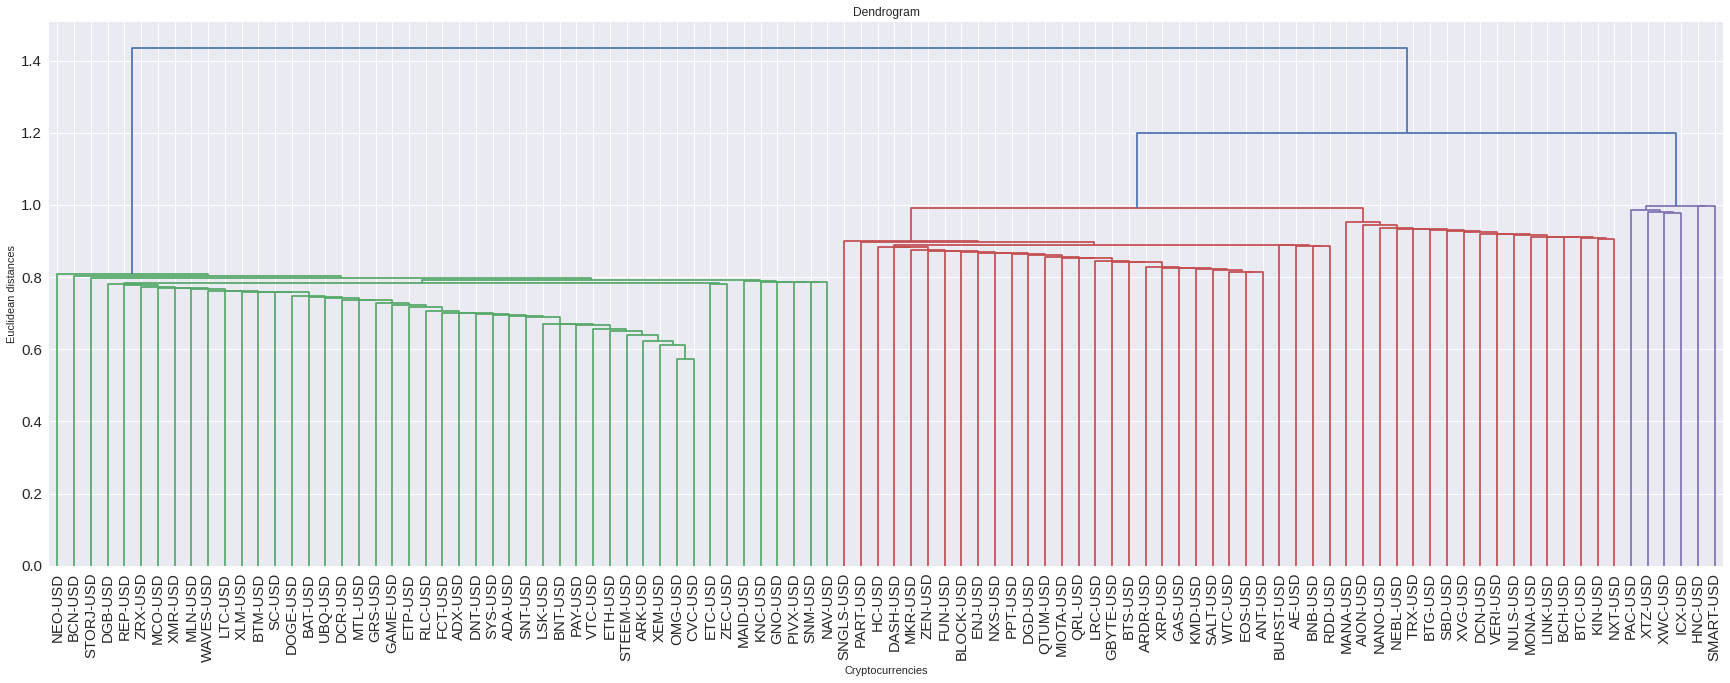

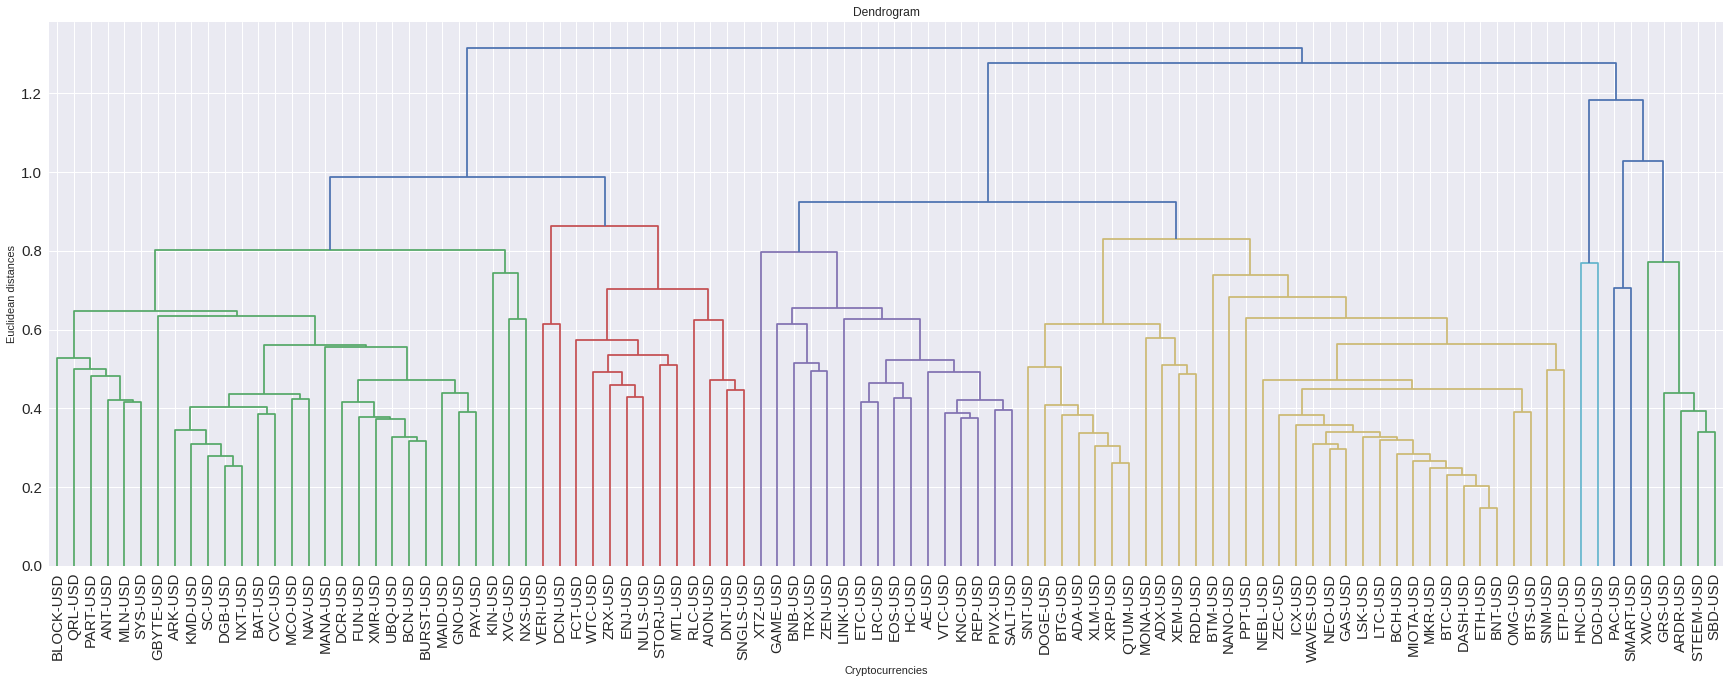

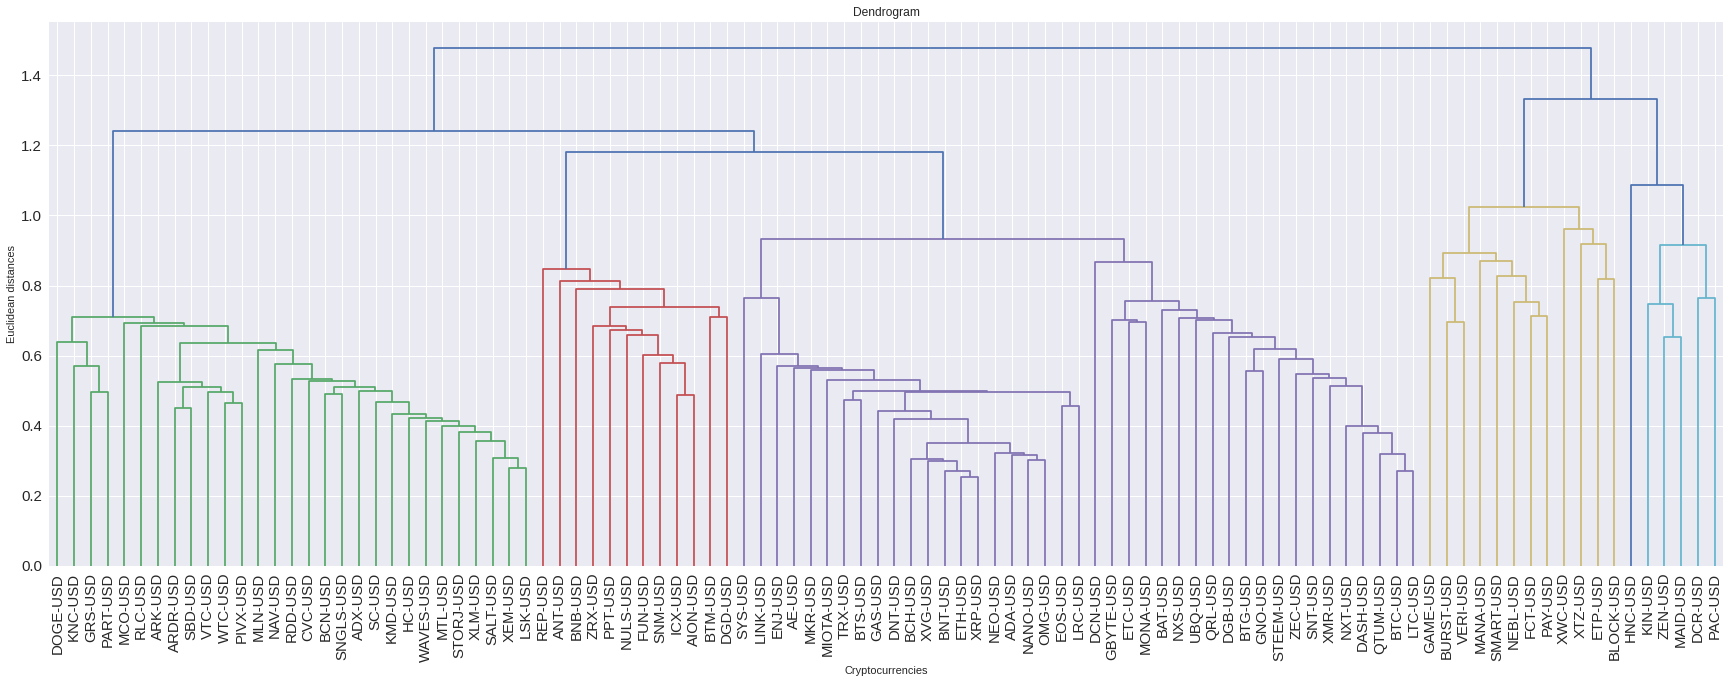

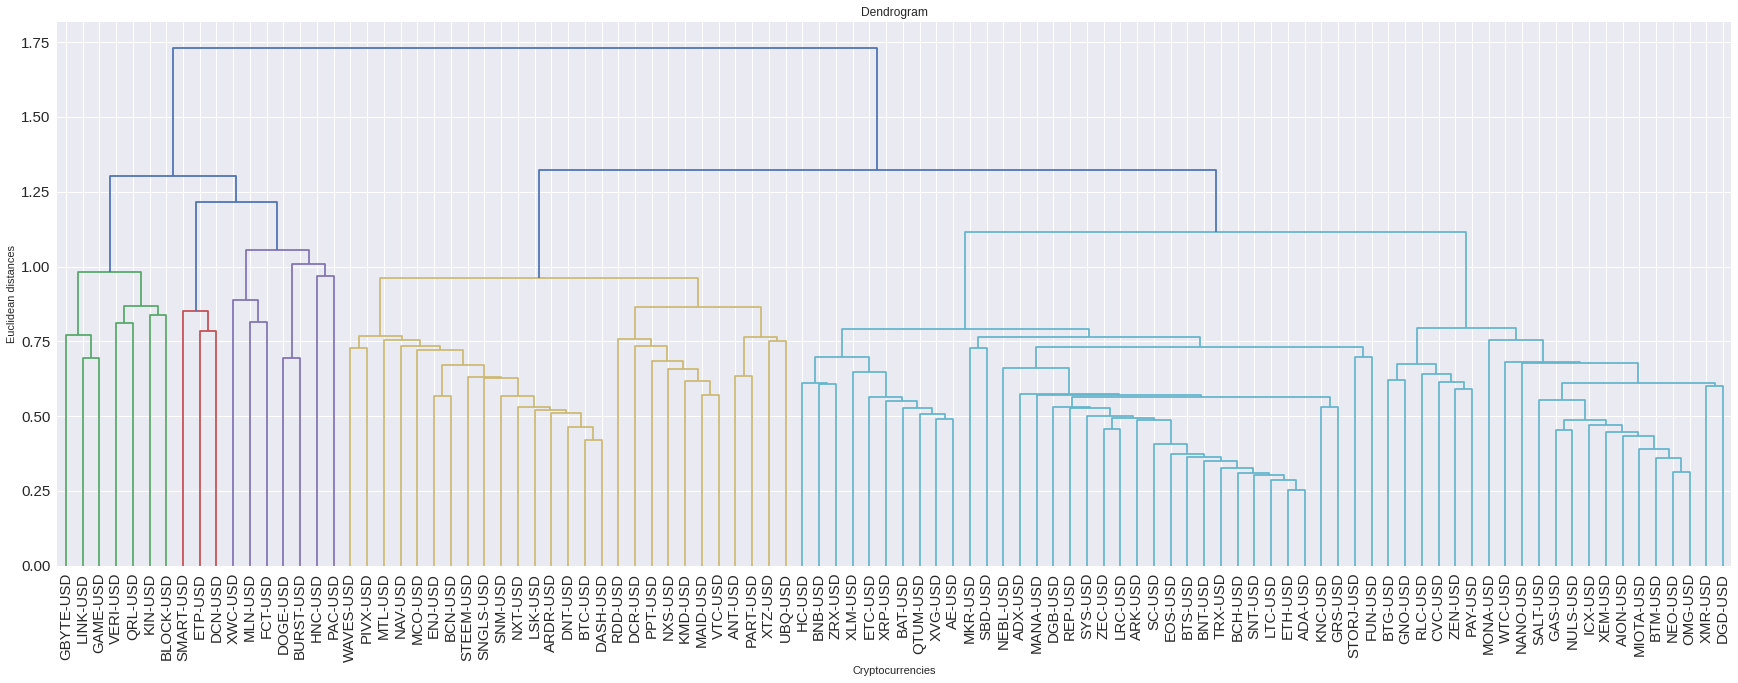

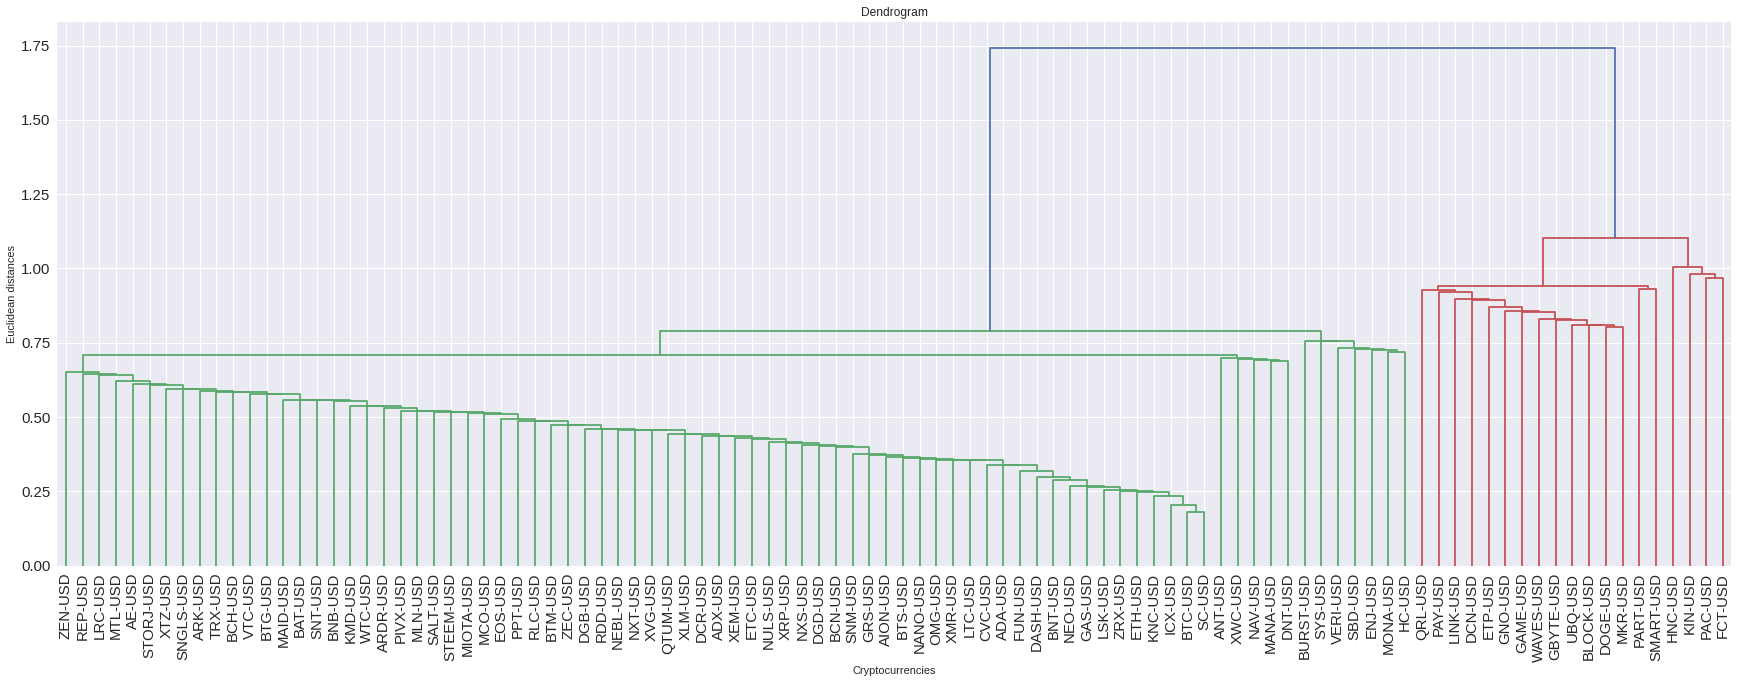

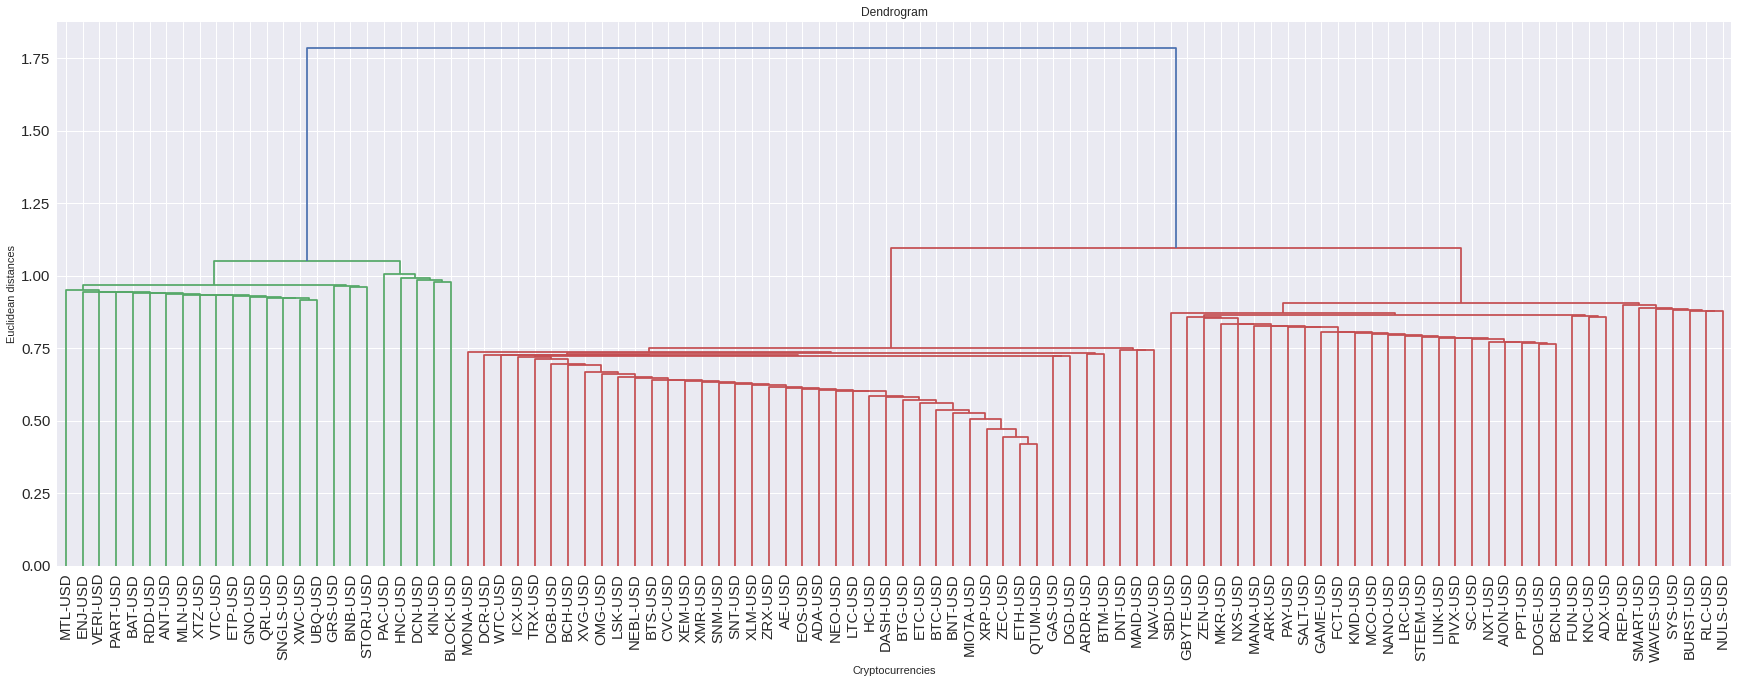

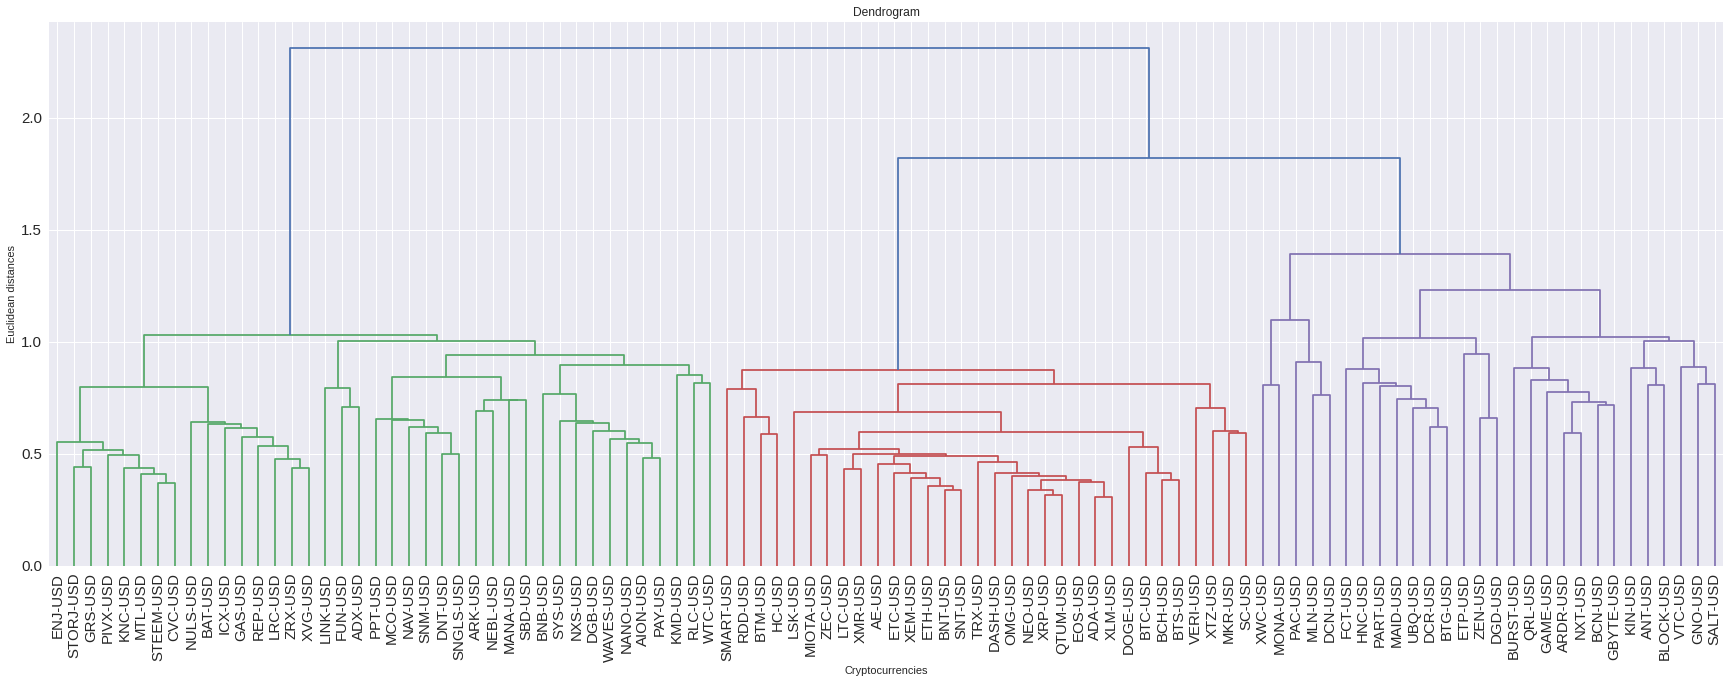

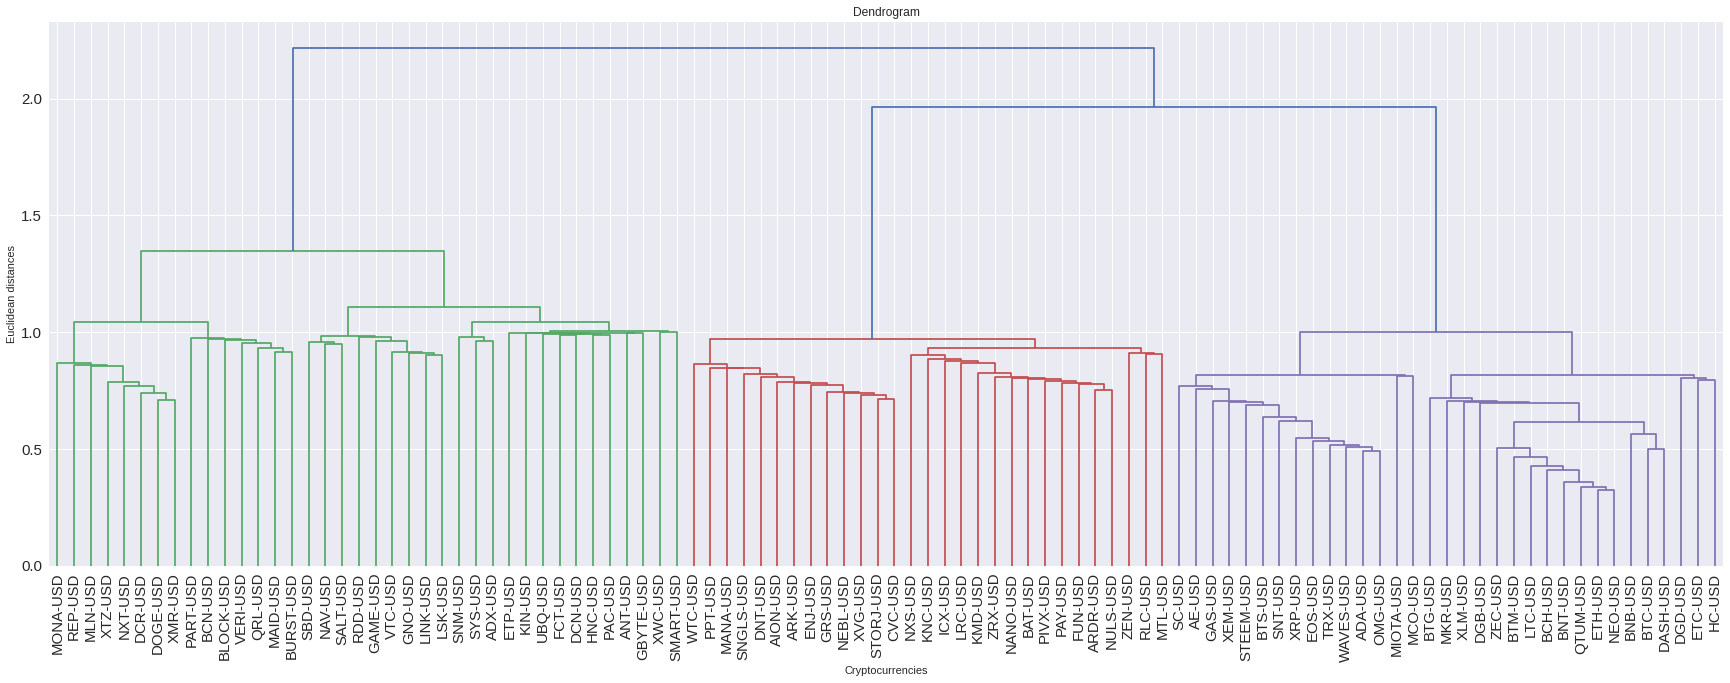

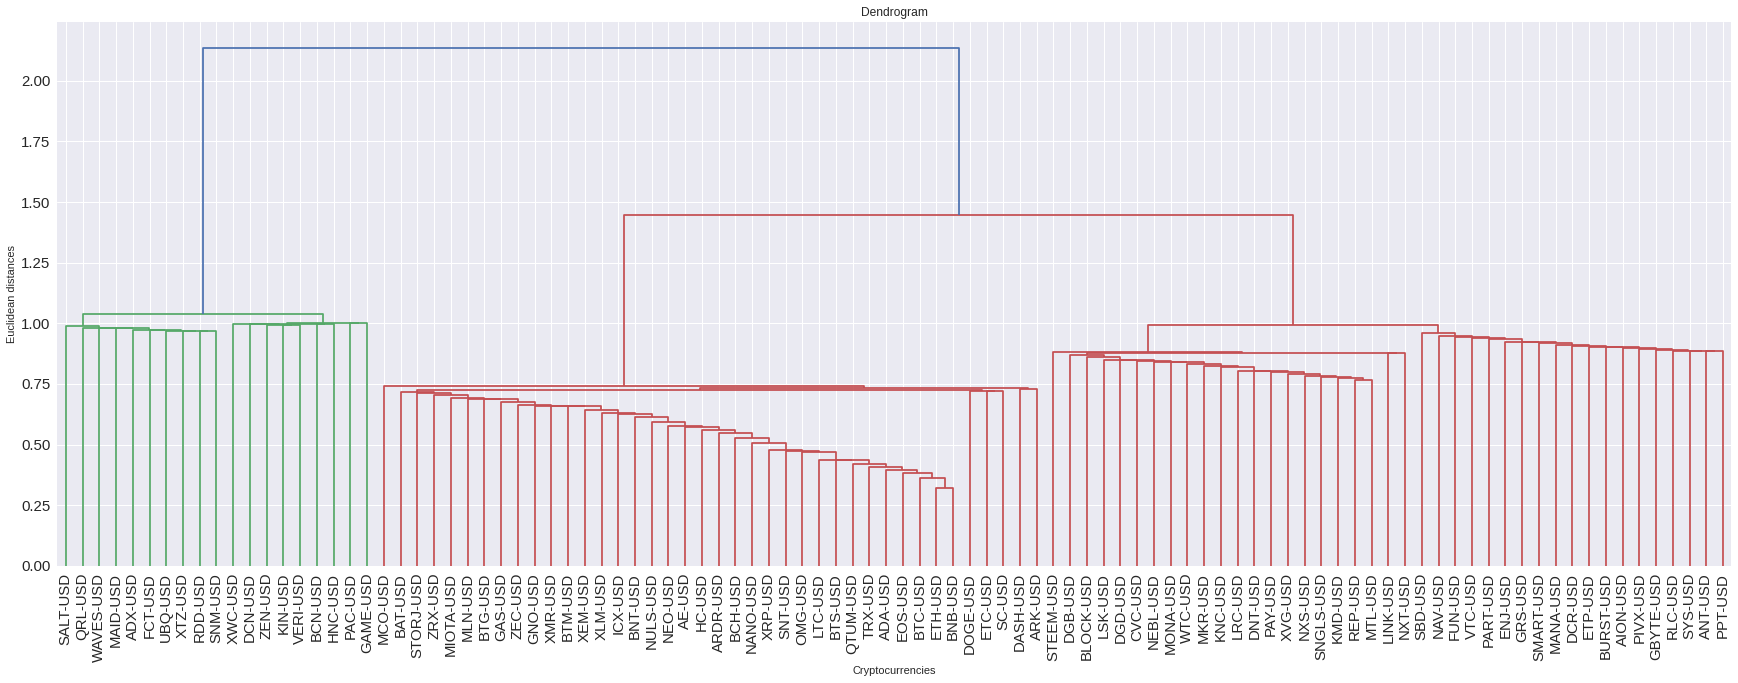

In [163]:
size = 120      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-30) if i < len(returns)-30]

[l_d.shape for l_d in list_of_dfs]
dendo = 0
for l_d in list_of_dfs:
    for col in l_d.columns:
        if (l_d[col].values == 0).all():
            l_d = l_d.drop(columns=col)
    tickers2 = l_d.columns
    ward_clustering(l_d, 30, tickers2, dendo=dendo) 
    dendo +=1

In [90]:
test_df = list_of_dfs[0]

In [102]:
for col in test_df.columns:
    if (test_df[col].values == 0).all():
        test_df = test_df.drop(columns=col)
        print(col)

[40.91840492]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,ARK-USD,BTC-USD,CVC-USD,OMG-USD,XEM-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,AE-USD,ANT-USD,ARDR-USD,BCN-USD,BLOCK-USD,BNB-USD,BTM-USD,BTS-USD,DASH-USD,DGB-USD,DGD-USD,ENJ-USD,EOS-USD,ETC-USD,FUN-USD,GAS-USD,GBYTE-USD,GNO-USD,HC-USD,KMD-USD,KNC-USD,LRC-USD,LTC-USD,MAID-USD,MCO-USD,MIOTA-USD,MKR-USD,MLN-USD,NAV-USD,NEO-USD,NXS-USD,PIVX-USD,PPT-USD,QRL-USD,QTUM-USD,RDD-USD,REP-USD,SALT-USD,SC-USD,SNM-USD,STORJ-USD,WAVES-USD,WTC-USD,XLM-USD,XMR-USD,XRP-USD,ZEC-USD,ZEN-USD,ZRX-USD
3,AION-USD,BCH-USD,BTG-USD,BURST-USD,DCN-USD,ICX-USD,KIN-USD,LINK-USD,MANA-USD,MONA-USD,NANO-USD,NEBL-USD,NULS-USD,NXT-USD,PART-USD,SBD-USD,SNGLS-USD,TRX-USD,VERI-USD,XVG-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,ADA-USD,ADX-USD,BAT-USD,BNT-USD,DCR-USD,DNT-USD,DOGE-USD,ETH-USD,ETP-USD,FCT-USD,GAME-USD,GRS-USD,LSK-USD,MTL-USD,PAY-USD,RLC-USD,SNT-USD,STEEM-USD,SYS-USD,UBQ-USD,VTC-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,HNC-USD,PAC-USD,SMART-USD,XTZ-USD,XWC-USD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


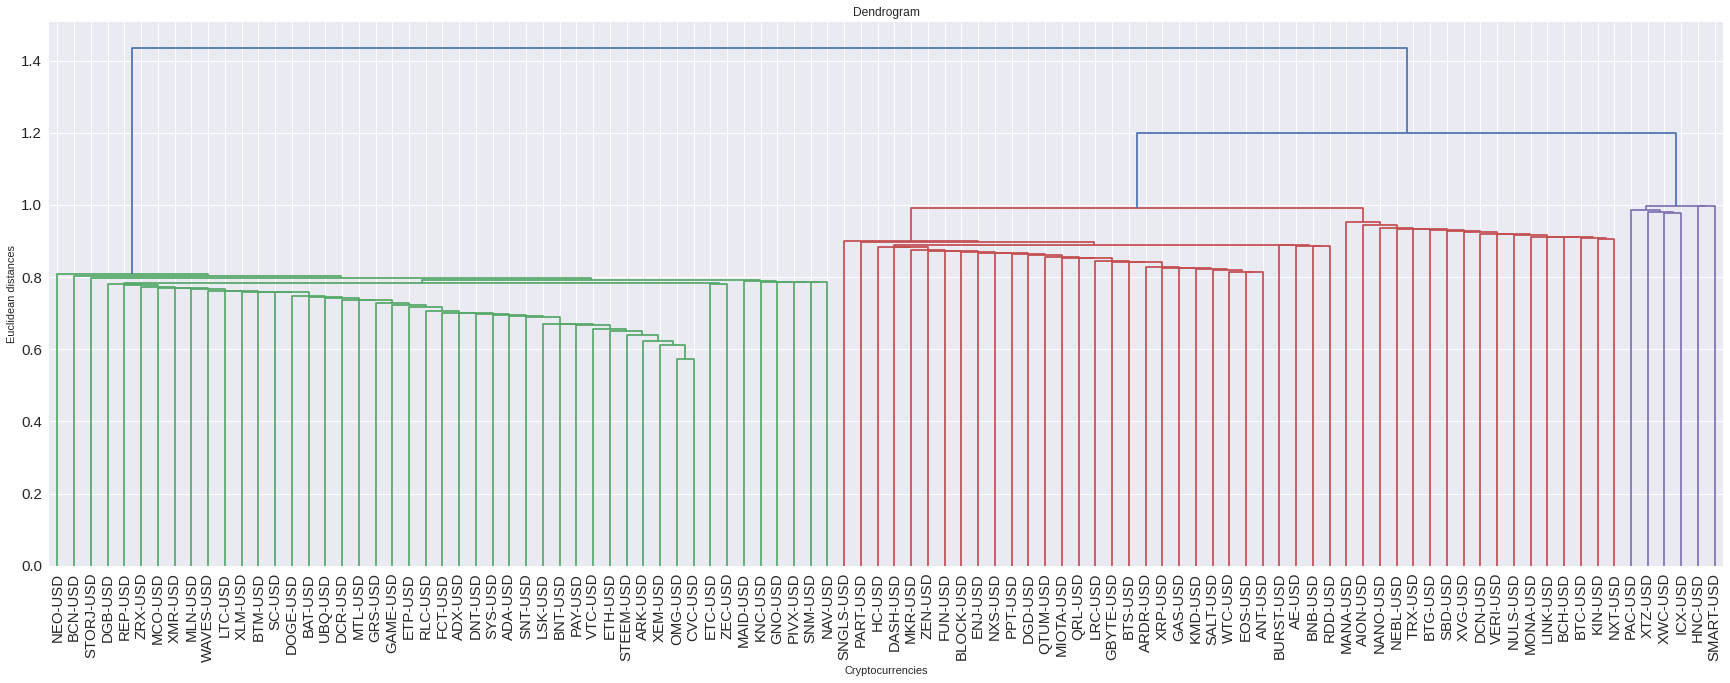

In [105]:
tickers_new = test_df.columns
ward_clustering(test_df, 30, tickers_new, dendo=1) 
